# Laboratorium 3

### Konfiguracja

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [51]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

<IPython.core.display.Javascript object>


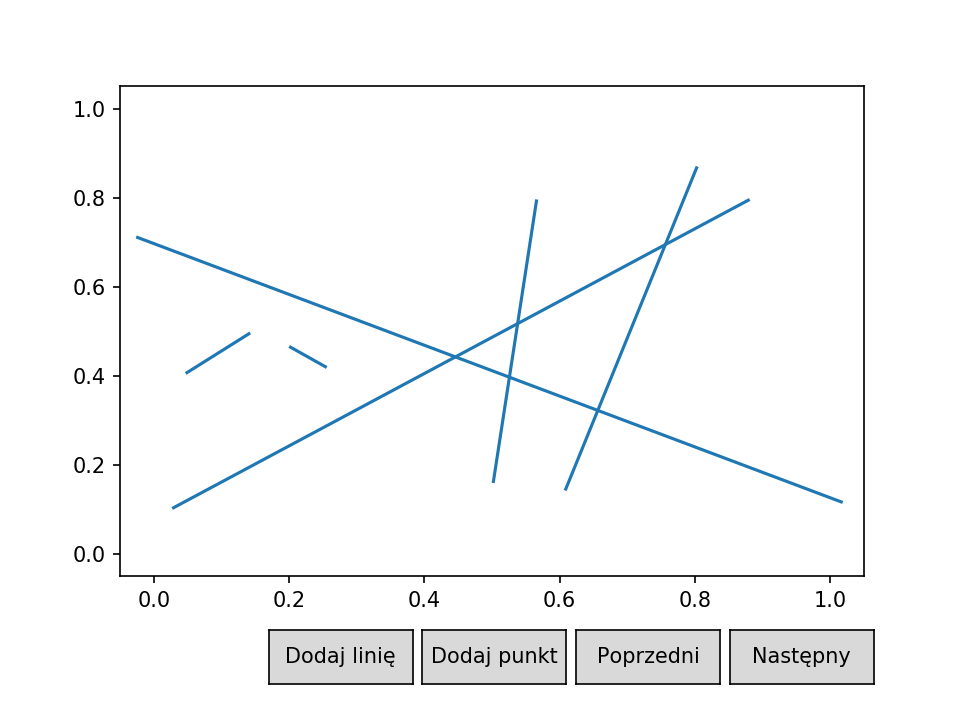

In [52]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

## Test set 

In [53]:
lines_collections = plot1.get_added_lines()
interactive_set = []
for lines_collection in lines_collections:
    for line in lines_collection.lines:
        interactive_set .append(line)
for points in interactive_set :
    if points[0][0] > points[1][0]:
        points[0], points[1] = points[1], points[0]

### Rozwiązanie

In [54]:
import random
from enum import Enum
from queue import PriorityQueue
from sortedcontainers import SortedSet
from tree import RBTree
import copy

eps = 10 ** (-6)

In [55]:
def det(a,b,c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

def orientation_rel_to_line(point, segment):
    orientation = det(segment[0], segment[1], point)
    if orientation < -eps:
        return -1
    elif orientation > eps:
        return 1
    else:
        return 0
    

def count_ab(Point):
    return ((Point[1][1] - Point[0][1]) / (Point[1][0] - Point[0][0]),
            Point[0][1] - Point[0][0] * ((Point[1][1] - Point[0][1]) / (Point[1][0] - Point[0][0])))


def count_y(segment, point):
    a, b = count_ab(segment)
    return a * point + b

## Random lines

In [56]:
def random_segment(x_min, x_max, y_min, y_max, n):
    ss = SortedSet([], key=lambda x: x[1][0])
    for i in range(n):
       point1 = (random.uniform(x_min, x_max), random.uniform(y_min, y_max))
       point2 = (random.uniform(point1[0], x_max), random.uniform(y_min, y_max))
       if point1[0] != point2[0]:
        ss.add((point1, point2))
    return ss

## One point intersection

In [57]:
class StateSegment:
    def __init__(self, segment):
        self.segment = segment
        self.start = segment[0]
        self.end = segment[0]
        self.orientation_point = self.start
    
    def __lt__(self, other):
        orientation = None
        if self.orientation_point[0] >= other.orientation_point[0]:
            orientation = orientation_rel_to_line(self.orientation_point, other.segment)
        else:
            orientation = -orientation_rel_to_line(other.orientation_point, self.segment)
        
        return (orientation == 1) or (orientation == 0 and orientation_rel_to_line(self.end, other.segment) == -1)
    
    def __eq__(self, other):
        return (
                self.start[0] == other.start[0]
               and self.start[1] == other.start[1]
               and self.end[0] == other.end[0]
               and self.end[1] == other.end[1]) 
    
    def __hash__(self):
        return hash(self.segment)
    
    def __le__(self, other):
        return self < other or self == other


def find_intersection(segment1, segment2):
    a1, b1 = count_ab(segment1)
    a2, b2 = count_ab(segment2)
    a = (a1 - a2)
    b = (b2 - b1)
    if a == 0:
        return -99999
    intersection = b/a
    if segment1[0][0] < intersection < segment1[1][
        0] and segment2[0][0] < intersection < segment2[1][0]:
        return (intersection, count_y(segment1, intersection))
    return None


def find_one_intersection(segments):
    scenes = []
    q = PriorityQueue()
    T = RBTree()
    for segment in segments:
        q.put((segment[0][0], segment))
        q.put((segment[1][0], segment))
    while not q.empty():
        point, segment = q.get()
        state_segment = StateSegment(segment)
        if point == segment[0][0]:
            T.insert(state_segment)
            scenes.append(Scene([PointsCollection([(point, count_y(segment, point))], color="green")],
                                [LinesCollection(segments),
                                LinesCollection([[[point,0], [point, 1]]], color="black")]))
            neighbour_1 = T.successor(state_segment)
            neighbour_2 = T.predecessor(state_segment)
            if neighbour_1 is not None:                
                intersection = find_intersection(neighbour_1.segment, segment)
                if intersection is not None:
                    return intersection, scenes
            if neighbour_2 is not None: 
                intersection = find_intersection(neighbour_2.segment, segment)
                if intersection is not None:
                    return intersection, scenes
        else:
            neighbour_1 = T.successor(state_segment)
            neighbour_2 = T.predecessor(state_segment)
            if neighbour_1 is not None and neighbour_2 is not None:
                intersection = find_intersection(neighbour_1.segment, neighbour_2.segment)
                if intersection is not None:
                    return intersection, scenes
            T.remove(state_segment)
            scenes.append(Scene([PointsCollection([[point, count_y(segment, point)]], color="green")],
                                    [LinesCollection(segments),
                                     LinesCollection([[[point,0], [point, 1]]], color="black")]))
    return None, scenes

<IPython.core.display.Javascript object>


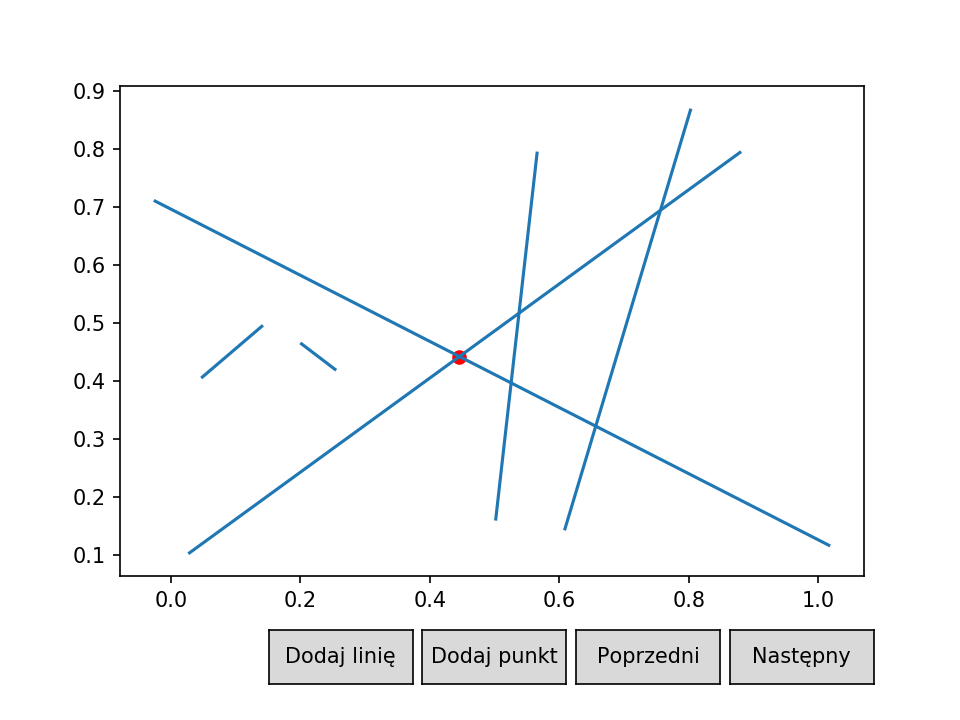

In [61]:
point, scenes_1 = find_one_intersection(interactive_set)

scenes_1.append(Scene([PointsCollection([point], color = "red")],
              [LinesCollection(interactive_set)]))

plot_one_point = Plot(scenes_1)
plot_one_point.draw()

## Every intersections

In [59]:
class PrioritySet(object):
    def __init__(self):
        self.queue = PriorityQueue()
        self.set = set()

    def put(self, element):
        index, segment = element
        if not index in self.set :
            self.queue.put(element)
            self.set.add(index)

    def get(self):
        return self.queue.get()
    
    def empty(self):
        return self.queue.empty()


# 3 segments can't cross in one point
def event_process(event_segment, q, T):
    neighbour_1 = T.predecessor(event_segment)
    neighbour_2 = T.successor(event_segment)
    if neighbour_1 is not None:                
        intersection = find_intersection(neighbour_1.segment, event_segment.segment)
        if intersection is not None:
            q.put((intersection[0], {
                        "neighbour_1": neighbour_1,
                        "neighbour_2": event_segment
                    }))
    if neighbour_2 is not None: 
        intersection = find_intersection(neighbour_2.segment, event_segment.segment)
        if intersection is not None:
            q.put((intersection[0], {
                        "neighbour_1": event_segment,
                        "neighbour_2": neighbour_2
                    }))



def find_every_intersections(segments):
    scenes = []
    res = []
    q = PrioritySet()
    T = RBTree()
    for segment in segments:
        q.put((segment[0][0], segment))
        q.put((segment[1][0], segment))        
    while not q.empty():
        point, segment = q.get()
        if type(segment) is list:
            if point == segment[0][0]:
                event_segment = StateSegment(segment)            
                T.insert(event_segment)
                event_process(event_segment, q, T)
                scenes.append(Scene([PointsCollection([[point, count_y(segment, point)]], color="green"),
                                        PointsCollection(copy.deepcopy(res), color="red")],
                                        [LinesCollection(segments),
                                        LinesCollection([[[point,0], [point, 1]]], color="black")]))
            else:           
                event_segment = StateSegment(segment)
                neighbour_1 = T.predecessor(event_segment)
                neighbour_2 = T.successor(event_segment)
                # after remove segment may its neighbours cross?
                if neighbour_1 is not None and neighbour_2 is not None:
                    intersection = find_intersection(neighbour_1.segment, neighbour_2.segment)
                    if intersection is not None:
                        q.put((intersection[0], {
                                "neighbour_1": neighbour_1,
                                "neighbour_2": neighbour_2,
                            }))
                T.remove(event_segment)
                scenes.append(Scene([PointsCollection([[point, count_y(segment, point)]], color="green"),
                                        PointsCollection(copy.deepcopy(res), color="red")],
                                        [LinesCollection(segments),
                                        LinesCollection([[[point,0], [point, 1]]], color="black")]))
        else: # only intersection left
            segment_1 = segment["neighbour_1"]
            segment_2 = segment["neighbour_2"]        
            T.remove(segment_1)
            T.remove(segment_2)
            # swap segments after intersection
            segment_1.orientation_point = (point, count_y(segment_1.segment, point))
            segment_2.orientation_point = (point, count_y(segment_2.segment, point))
            T.insert(segment_1)
            event_process(segment_1, q, T)
            T.insert(segment_2)
            event_process(segment_2, q, T)
            scenes.append(Scene([PointsCollection([[point, count_y(segment_1.segment, point)]], color="green"),
                                    PointsCollection(copy.deepcopy(res), color="red")],
                                    [LinesCollection(segments),
                                    LinesCollection([[[point,0], [point, 1]]], color="black")]))
            res.append([point, count_y(segment_1.segment, point)])
    return res, scenes

<IPython.core.display.Javascript object>


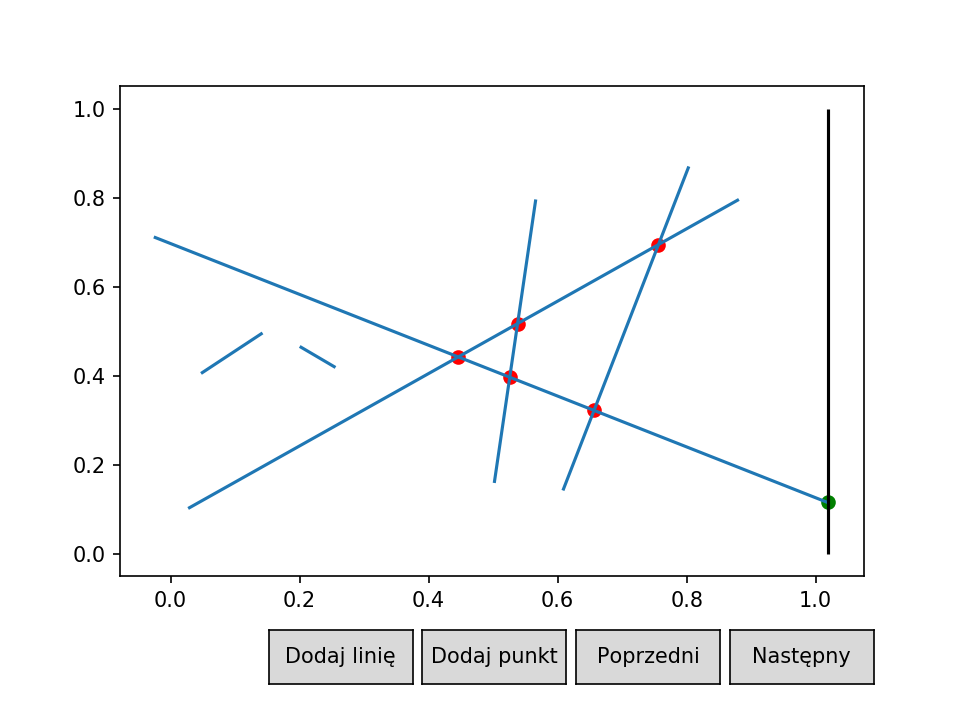

5


In [62]:
%matplotlib notebook


results, scenes = find_every_intersections(interactive_set)
plot = Plot(scenes)
plot.draw()
print(len(results))